In [1]:
!pip install --no-index /kaggle/input/imc2024-packages-lightglue-rerun-kornia/* --no-deps
!mkdir -p /root/.cache/torch/hub/checkpoints
!cp /kaggle/input/aliked/pytorch/aliked-n16/1/* /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/lightglue/pytorch/aliked/1/* /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/lightglue/pytorch/aliked/1/aliked_lightglue.pth /root/.cache/torch/hub/checkpoints/aliked_lightglue_v0-1_arxiv-pth

Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia-0.7.2-py2.py3-none-any.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia_moons-0.2.9-py3-none-any.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/kornia_rs-0.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/lightglue-0.0-py3-none-any.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/pycolmap-0.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing /kaggle/input/imc2024-packages-lightglue-rerun-kornia/rerun_sdk-0.15.0a2-cp38-abi3-manylinux_2_31_x86_64.whl
kornia is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
kornia-rs is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
# General utilities
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
from pathlib import Path
from time import time, sleep
from fastprogress import progress_bar
import gc
import numpy as np
import h5py
from IPython.display import clear_output
from collections import defaultdict
from copy import deepcopy
from typing import Any
import itertools
import pandas as pd

# CV/MLe
import cv2
import torch
from torch import Tensor as T
import torch.nn.functional as F
import kornia as K
import kornia.feature as KF
from PIL import Image
from transformers import AutoImageProcessor, AutoModel

import torch
from lightglue import match_pair
from lightglue import LightGlue, ALIKED
from lightglue.utils import load_image, rbd

# 3D reconstruction
import pycolmap

# Data importing into colmap
import sys
sys.path.append("/kaggle/input/colmap-db-import")

# Provided by organizers
from database import *
from h5_to_db import *

def arr_to_str(a):
    """Returns ;-separated string representing the input"""
    return ";".join([str(x) for x in a.reshape(-1)])

def load_torch_image(file_name: Path | str, device=torch.device("cpu")):
    """Loads an image and adds batch dimension"""
    img = K.io.load_image(file_name, K.io.ImageLoadType.RGB32, device=device)[None, ...]
    return img

device = K.utils.get_cuda_device_if_available(0)
print(device)

DEBUG = len([p for p in Path("/kaggle/input/image-matching-challenge-2024/test/").iterdir() if p.is_dir()]) == 2
print("DEBUG:", DEBUG)

2024-04-01 10:50:55.166629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 10:50:55.166757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 10:50:55.304816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cuda:0
DEBUG: True


In [3]:
def embed_images(
    paths: list[Path],
    model_name: str,
    device: torch.device = torch.device("cpu"),
) -> T:
    """Computes image embeddings.
    
    Returns a tensor of shape [len(filenames), output_dim]
    """
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).eval().to(device)
    
    embeddings = []
    
    for i, path in tqdm(enumerate(paths), desc="Global descriptors"):
        image = load_torch_image(path)
        
        with torch.inference_mode():
            inputs = processor(images=image, return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs) # last_hidden_state and pooled
            
            # Max pooling over all the hidden states but the first (starting token)
            # To obtain a tensor of shape [1, output_dim]
            # We normalize so that distances are computed in a better fashion later
            embedding = F.normalize(outputs.last_hidden_state[:,1:].max(dim=1)[0], dim=-1, p=2)
            
        embeddings.append(embedding.detach().cpu())
    return torch.cat(embeddings, dim=0)

In [4]:
def get_pairs_exhaustive(lst: list[Any]) -> list[tuple[int, int]]:
    """Obtains all possible index pairs of a list"""
    return list(itertools.combinations(range(len(lst)), 2))            
    
def get_image_pairs(
    paths: list[Path],
    model_name: str,
    similarity_threshold: float = 0.6,
    tolerance: int = 1000,
    min_matches: int = 20,
    exhaustive_if_less: int = 20,
    p: float = 2.0,
    device: torch.device = torch.device("cpu"),
) -> list[tuple[int, int]]:
    """Obtains pairs of similar images"""
    if len(paths) <= exhaustive_if_less:
        return get_pairs_exhaustive(paths)
    
    matches = []
    
    # Embed images and compute distances for filtering
    embeddings = embed_images(paths, model_name)
    distances = torch.cdist(embeddings, embeddings, p=p)
    
    # Remove pairs above similarity threshold (if enough)
    mask = distances <= similarity_threshold
    image_indices = np.arange(len(paths))
    
    for current_image_index in range(len(paths)):
        mask_row = mask[current_image_index]
        indices_to_match = image_indices[mask_row]
        
        # We don't have enough matches below the threshold, we pick most similar ones
        if len(indices_to_match) < min_matches:
            indices_to_match = np.argsort(distances[current_image_index])[:min_matches]
            
        for other_image_index in indices_to_match:
            # Skip an image matching itself
            if other_image_index == current_image_index:
                continue
            
            # We need to check if we are below a certain distance tolerance 
            # since for images that don't have enough matches, we picked
            # the most similar ones (which could all still be very different 
            # to the image we are analyzing)
            if distances[current_image_index, other_image_index] < tolerance:
                # Add the pair in a sorted manner to avoid redundancy
                matches.append(tuple(sorted((current_image_index, other_image_index.item()))))
                
    return sorted(list(set(matches)))

In [5]:
if DEBUG:
    images_list = list(Path("/kaggle/input/image-matching-challenge-2024/test/church/images/").glob("*.png"))[:10]
    index_pairs = get_image_pairs(images_list, "/kaggle/input/dinov2/pytorch/base/1")
    print(index_pairs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


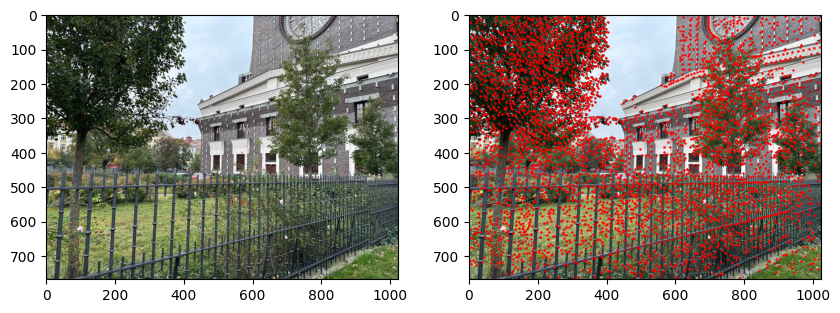

In [6]:
if DEBUG:
    dtype = torch.float32 # ALIKED has issues with float16

    extractor = ALIKED(
            max_num_keypoints=4096, 
            detection_threshold=0.01, 
            resize=1024
        ).eval().to(device, dtype)

    path = images_list[0]
    image = load_torch_image(path, device=device).to(dtype)
    features = extractor.extract(image)

    fig, ax = plt.subplots(1, 2, figsize=(10, 20))
    ax[0].imshow(image[0, ...].permute(1,2,0).cpu())
    ax[1].imshow(image[0, ...].permute(1,2,0).cpu())
    ax[1].scatter(features["keypoints"][0, :, 0].cpu(), features["keypoints"][0, :, 1].cpu(), s=0.5, c="red")

    del extractor

In [7]:
def detect_keypoints(
    paths: list[Path],
    feature_dir: Path,
    num_features: int = 4096,
    resize_to: int = 1024,
    device: torch.device = torch.device("cpu"),
) -> None:
    """Detects the keypoints in a list of images with ALIKED
    
    Stores them in feature_dir/keypoints.h5 and feature_dir/descriptors.h5
    to be used later with LightGlue
    """
    dtype = torch.float32 # ALIKED has issues with float16
    
    extractor = ALIKED(
        max_num_keypoints=num_features, 
        detection_threshold=0.01, 
        resize=resize_to
    ).eval().to(device, dtype)
    
    feature_dir.mkdir(parents=True, exist_ok=True)
    
    with h5py.File(feature_dir / "keypoints.h5", mode="w") as f_keypoints, \
         h5py.File(feature_dir / "descriptors.h5", mode="w") as f_descriptors:
        
        for path in tqdm(paths, desc="Computing keypoints"):
            key = path.name
            
            with torch.inference_mode():
                image = load_torch_image(path, device=device).to(dtype)
                features = extractor.extract(image)
                
                f_keypoints[key] = features["keypoints"].squeeze().detach().cpu().numpy()
                f_descriptors[key] = features["descriptors"].squeeze().detach().cpu().numpy()

In [8]:
if DEBUG:
    feature_dir = Path("./sample_test_features")
    detect_keypoints(images_list, feature_dir)

Computing keypoints: 100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


In [9]:
if DEBUG:
    matcher_params = {
        "width_confidence": -1,
        "depth_confidence": -1,
        "mp": True if 'cuda' in str(device) else False,
    }
    matcher = KF.LightGlueMatcher("aliked", matcher_params).eval().to(device)

    with h5py.File(feature_dir / "keypoints.h5", mode="r") as f_keypoints, \
         h5py.File(feature_dir / "descriptors.h5", mode="r") as f_descriptors:
            idx1, idx2 = index_pairs[0]
            key1, key2 = images_list[idx1].name, images_list[idx2].name

            keypoints1 = torch.from_numpy(f_keypoints[key1][...]).to(device)
            keypoints2 = torch.from_numpy(f_keypoints[key2][...]).to(device)
            print("Keypoints:", keypoints1.shape, keypoints2.shape)
            descriptors1 = torch.from_numpy(f_descriptors[key1][...]).to(device)
            descriptors2 = torch.from_numpy(f_descriptors[key2][...]).to(device)
            print("Descriptors:", descriptors1.shape, descriptors2.shape)

            with torch.inference_mode():
                distances, indices = matcher(
                    descriptors1, 
                    descriptors2, 
                    KF.laf_from_center_scale_ori(keypoints1[None]),
                    KF.laf_from_center_scale_ori(keypoints2[None]),
                )
    print(distances, indices)

Loaded LightGlue model
Keypoints: torch.Size([4096, 2]) torch.Size([4096, 2])
Descriptors: torch.Size([4096, 128]) torch.Size([4096, 128])
tensor([[0.1330],
        [0.1201],
        [0.1239],
        [0.1855],
        [0.3038],
        [0.1823],
        [0.2494],
        [0.1812],
        [0.7277],
        [0.1016],
        [0.2919],
        [0.2763],
        [0.3639],
        [0.1954],
        [0.1899],
        [0.2098],
        [0.3901],
        [0.4396],
        [0.1359],
        [0.4628],
        [0.1639],
        [0.3304],
        [0.1028],
        [0.1307],
        [0.1967],
        [0.1284],
        [0.1092],
        [0.1578]], device='cuda:0') tensor([[  36,  233],
        [ 386,  152],
        [ 388, 1861],
        [ 455,  337],
        [ 737, 1013],
        [ 968,  222],
        [1028, 1351],
        [1038, 1572],
        [1199,  194],
        [1224, 2435],
        [1337, 1668],
        [1540,  564],
        [1615, 3561],
        [1684,  396],
        [1711, 1196],
        [

In [10]:
def keypoint_distances(
    paths: list[Path],
    index_pairs: list[tuple[int, int]],
    feature_dir: Path,
    min_matches: int = 15,
    verbose: bool = True,
    device: torch.device = torch.device("cpu"),
) -> None:
    """Computes distances between keypoints of images.
    
    Stores output at feature_dir/matches.h5
    """
    
    matcher_params = {
        "width_confidence": -1,
        "depth_confidence": -1,
        "mp": True if 'cuda' in str(device) else False,
    }
    matcher = KF.LightGlueMatcher("aliked", matcher_params).eval().to(device)
    
    with h5py.File(feature_dir / "keypoints.h5", mode="r") as f_keypoints, \
         h5py.File(feature_dir / "descriptors.h5", mode="r") as f_descriptors, \
         h5py.File(feature_dir / "matches.h5", mode="w") as f_matches:
        
            for idx1, idx2 in tqdm(index_pairs, desc="Computing keypoing distances"):
                key1, key2 = paths[idx1].name, paths[idx2].name

                keypoints1 = torch.from_numpy(f_keypoints[key1][...]).to(device)
                keypoints2 = torch.from_numpy(f_keypoints[key2][...]).to(device)
                descriptors1 = torch.from_numpy(f_descriptors[key1][...]).to(device)
                descriptors2 = torch.from_numpy(f_descriptors[key2][...]).to(device)

                with torch.inference_mode():
                    distances, indices = matcher(
                        descriptors1, 
                        descriptors2, 
                        KF.laf_from_center_scale_ori(keypoints1[None]),
                        KF.laf_from_center_scale_ori(keypoints2[None]),
                    )

                # We have matches to consider
                n_matches = len(indices)
                if n_matches:
                    if verbose:
                        print(f"{key1}-{key2}: {n_matches} matches")
                    # Store the matches in the group of one image
                    if n_matches >= min_matches:
                        group  = f_matches.require_group(key1)
                        group.create_dataset(key2, data=indices.detach().cpu().numpy().reshape(-1, 2))

In [11]:
if DEBUG:
    keypoint_distances(images_list, index_pairs, feature_dir, verbose=False)

Loaded LightGlue model


Computing keypoing distances: 100%|██████████| 45/45 [13:06<00:00, 17.48s/it]


In [12]:
def import_into_colmap(
    path: Path,
    feature_dir: Path,
    database_path: str = "colmap.db",
) -> None:
    """Adds keypoints into colmap"""
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, path, "", "simple-pinhole", single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )
    db.commit()

In [13]:
if DEBUG:
    database_path = "colmap.db"
    images_dir = images_list[0].parent
    import_into_colmap(
        images_dir, 
        feature_dir, 
        database_path,
    )

    # This does RANSAC
    pycolmap.match_exhaustive(database_path)

 97%|█████████▋| 35/36 [00:00<00:00, 3411.67it/s]
I20240401 11:04:43.540452    76 misc.cc:198] 
Exhaustive feature matching
I20240401 11:04:43.541447    76 feature_matching.cc:231] Matching block [1/1, 1/1]
I20240401 11:04:44.289934    76 feature_matching.cc:46]  in 0.749s
I20240401 11:04:44.290696    76 timer.cc:91] Elapsed time: 0.013 [minutes]


In [14]:
if DEBUG:
    mapper_options = pycolmap.IncrementalPipelineOptions()
    mapper_options.min_model_size = 3
    mapper_options.max_num_models = 2

    maps = pycolmap.incremental_mapping(
        database_path=database_path, 
        image_path=images_dir,
        output_path=Path.cwd() / "incremental_pipeline_outputs", 
        options=mapper_options,
    )

I20240401 11:04:44.342440    85 misc.cc:198] 
Loading database
I20240401 11:04:44.344065    85 database_cache.cc:54] Loading cameras...
I20240401 11:04:44.344214    85 database_cache.cc:64]  10 in 0.000s
I20240401 11:04:44.344282    85 database_cache.cc:72] Loading matches...
I20240401 11:04:44.344503    85 database_cache.cc:78]  31 in 0.000s
I20240401 11:04:44.344543    85 database_cache.cc:94] Loading images...
I20240401 11:04:44.346851    85 database_cache.cc:143]  10 in 0.002s (connected 10)
I20240401 11:04:44.346889    85 database_cache.cc:154] Building correspondence graph...
I20240401 11:04:44.348623    85 database_cache.cc:190]  in 0.002s (ignored 0)
I20240401 11:04:44.348660    85 timer.cc:91] Elapsed time: 0.000 [minutes]
I20240401 11:04:44.349647    85 misc.cc:198] 
Finding good initial image pair
I20240401 11:04:44.379874    85 misc.cc:198] 
Initializing with image pair #7 and #6
I20240401 11:04:44.381942    85 misc.cc:198] 
Global bundle adjustment


iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.804144e+04    0.00e+00    3.46e+06   0.00e+00   0.00e+00  1.00e+04        0    1.22e-03    3.66e-03
   1  1.091763e+06   -1.01e+06    3.46e+06   5.08e+02  -2.20e+01  5.00e+03        1    1.82e-03    5.53e-03
   2  1.264306e+05   -4.84e+04    3.46e+06   2.81e+02  -1.13e+00  1.25e+03        1    1.37e-03    6.92e-03
   3  3.843923e+04    3.96e+04    7.32e+04   1.59e+02   1.01e+00  3.75e+03        1    2.51e-03    9.45e-03
   4  6.376848e+04   -2.53e+04    7.32e+04   2.07e+02  -5.26e+00  1.88e+03        1    1.51e-03    1.10e-02
   5  3.742357e+04    1.02e+03    4.57e+05   1.03e+02   3.51e-01  1.83e+03        1    2.46e-03    1.35e-02
   6  3.494388e+04    2.48e+03    6.99e+05   1.05e+02   4.85e-01  1.83e+03        1    2.47e-03    1.60e-02
   7  3.200349e+04    2.94e+03    9.38e+05   1.07e+02   4.00e-01  1.81e+03        1    2.66e-03    1.86e-02
   8  2.727178e+04    4.73e+

I20240401 11:04:44.643648    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:44.643709    85 bundle_adjustment.cc:942] 
    Residuals : 2552
   Parameters : 1921
   Iterations : 101
         Time : 0.26006 [s]
 Initial cost : 5.52996 [px]
   Final cost : 0.432239 [px]
  Termination : No convergence

I20240401 11:04:44.644749    85 incremental_mapper.cc:160] => Filtered observations: 0
I20240401 11:04:44.644800    85 incremental_mapper.cc:167] => Filtered images: 0
I20240401 11:04:44.662611    85 misc.cc:198] 
Registering image #10 (3)
I20240401 11:04:44.662657    85 incremental_mapper.cc:495] => Image sees 146 / 538 points
I20240401 11:04:44.690186    85 misc.cc:205] 
Pose refinement report
----------------------
I20240401 11:04:44.690258    85 bundle_adjustment.cc:942] 
    Residuals : 286
   Parameters : 7
   Iterations : 43
         Time : 0.00748992 [s]
 Initial cost : 0.865172 [px]
   Final cost : 0.858004 [px]
  Termination : Convergence

I20240

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.356625e+03    0.00e+00    1.24e+04   0.00e+00   0.00e+00  1.00e+04        0    1.32e-03    3.82e-03
   1  8.984253e+03    3.72e+02    6.05e+04   8.41e+02   4.42e-01  9.98e+03        1    3.37e-03    7.22e-03
   2  8.492952e+03    4.91e+02    2.62e+04   6.88e+02   8.13e-01  1.32e+04        1    3.10e-03    1.03e-02
   3  8.346800e+03    1.46e+02    2.19e+04   7.86e+02   5.72e-01  1.33e+04        1    3.11e-03    1.35e-02
   4  8.197029e+03    1.50e+02    1.44e+04   6.74e+02   7.46e-01  1.50e+04        1    3.51e-03    1.70e-02
   5  8.112072e+03    8.50e+01    1.16e+04   6.55e+02   7.19e-01  1.64e+04        1    3.00e-03    2.00e-02
   6  8.052382e+03    5.97e+01    9.02e+03   6.11e+02   7.64e-01  1.92e+04        1    3.14e-03    2.32e-02
   7  8.015004e+03    3.74e+01    7.57e+03   6.10e+02   7.62e-01  2.25e+04        1    3.05e-03    2.63e-02
   8  7.990158e+03    2.48e+

I20240401 11:04:45.143486    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:45.143553    85 bundle_adjustment.cc:942] 
    Residuals : 2922
   Parameters : 2045
   Iterations : 100
         Time : 0.310512 [s]
 Initial cost : 1.78945 [px]
   Final cost : 1.64404 [px]
  Termination : Convergence

I20240401 11:04:45.144693    85 incremental_mapper.cc:175] => Completed observations: 1
I20240401 11:04:45.145013    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:45.145387    85 incremental_mapper.cc:160] => Filtered observations: 55
I20240401 11:04:45.145412    85 incremental_mapper.cc:119] => Changed observations: 0.038330
I20240401 11:04:45.145442    85 misc.cc:198] 
Global bundle adjustment
I20240401 11:04:45.215565    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:45.215634    85 bundle_adjustment.cc:942] 
    Residuals : 2814
   Parameters : 1988
   Iterations : 29
         Time : 0.068398 [

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.776019e+02    0.00e+00    4.13e+08   0.00e+00   0.00e+00  1.00e+04        0    1.35e-03    3.88e-03
   1  9.769686e+02    6.33e-01    4.61e+06   6.96e+00   9.99e-01  3.00e+04        1    3.42e-03    7.33e-03
   2  9.769470e+02    2.16e-02    2.38e+06   1.65e+01   9.97e-01  9.00e+04        1    3.33e-03    1.07e-02
   3  9.769316e+02    1.54e-02    3.69e+06   2.06e+01   1.00e+00  2.70e+05        1    3.14e-03    1.39e-02
   4  9.769283e+02    3.30e-03    1.23e+06   1.21e+01   1.02e+00  8.10e+05        1    3.14e-03    1.70e-02
   5  9.769281e+02    1.68e-04    6.63e+04   2.86e+00   1.05e+00  2.43e+06        1    3.14e-03    2.02e-02
   6  9.769281e+02    5.28e-06    1.15e+04   3.37e-01   1.52e+00  7.29e+06        1    3.11e-03    2.33e-02
   7  9.769281e+02    8.48e-07    1.75e+03   2.11e-01   4.81e-01  7.29e+06        1    3.27e-03    2.66e-02
   8  9.769281e+02    1.37e-

I20240401 11:04:45.799544    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:45.799607    85 bundle_adjustment.cc:942] 
    Residuals : 2930
   Parameters : 2022
   Iterations : 101
         Time : 0.302739 [s]
 Initial cost : 0.577627 [px]
   Final cost : 0.576259 [px]
  Termination : No convergence

I20240401 11:04:45.800762    85 incremental_mapper.cc:175] => Completed observations: 0
I20240401 11:04:45.801045    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:45.801385    85 incremental_mapper.cc:160] => Filtered observations: 0
I20240401 11:04:45.801409    85 incremental_mapper.cc:119] => Changed observations: 0.000000
I20240401 11:04:45.801425    85 incremental_mapper.cc:167] => Filtered images: 0
I20240401 11:04:45.820297    85 misc.cc:198] 
Registering image #2 (5)
I20240401 11:04:45.820343    85 incremental_mapper.cc:495] => Image sees 98 / 1085 points
I20240401 11:04:45.842471    85 misc.cc:205] 
Pose refinement repor

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.271300e+04    0.00e+00    3.16e+10   0.00e+00   0.00e+00  1.00e+04        0    1.62e-03    4.54e-03
   1  1.734386e+04   -4.63e+03    3.16e+10   1.08e+03  -7.11e-01  5.00e+03        1    2.51e-03    7.08e-03
   2  9.895294e+03    2.82e+03    1.24e+11   7.34e+02   4.40e-01  4.99e+03        1    3.50e-03    1.06e-02
   3  5.959275e+03    3.94e+03    1.59e+09   3.20e+02   9.99e-01  1.50e+04        1    3.96e-03    1.46e-02
   4  5.925087e+03    3.42e+01    1.35e+09   1.91e+02   9.96e-01  4.49e+04        1    3.45e-03    1.81e-02
   5  5.922188e+03    2.90e+00    6.09e+07   3.68e+01   1.04e+00  1.35e+05        1    3.47e-03    2.16e-02
   6  5.922152e+03    3.60e-02    1.40e+06   5.03e+00   1.09e+00  4.04e+05        1    3.42e-03    2.50e-02
   7  5.922152e+03    5.38e-04    1.73e+05   6.09e-01   1.13e+00  1.21e+06        1    3.52e-03    2.86e-02
   8  5.922152e+03    8.69e-

I20240401 11:04:46.349263    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:46.349328    85 bundle_adjustment.cc:942] 
    Residuals : 3252
   Parameters : 2242
   Iterations : 101
         Time : 0.357703 [s]
 Initial cost : 1.97719 [px]
   Final cost : 1.32908 [px]
  Termination : No convergence

I20240401 11:04:46.350613    85 incremental_mapper.cc:175] => Completed observations: 7
I20240401 11:04:46.350963    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:46.351383    85 incremental_mapper.cc:160] => Filtered observations: 84
I20240401 11:04:46.351413    85 incremental_mapper.cc:119] => Changed observations: 0.055966
I20240401 11:04:46.351447    85 misc.cc:198] 
Global bundle adjustment


  13  1.010162e+03    6.63e-03    2.43e+06   1.28e+01   1.00e+00  8.60e+09        1    3.40e-03    4.83e-02
  14  1.010142e+03    1.94e-02    2.23e+07   4.03e+01   9.96e-01  2.58e+10        1    3.57e-03    5.19e-02
  15  1.010093e+03    4.94e-02    2.11e+08   1.39e+02   8.97e-01  5.18e+10        1    3.28e-03    5.52e-02
  16  1.010052e+03    4.06e-02    7.96e+08   3.78e+02   4.17e-01  5.15e+10        1    3.31e-03    5.85e-02
  17  1.009942e+03    1.10e-01    4.19e+08   5.42e+02   9.03e-01  1.08e+11        1    3.53e-03    6.21e-02
  18  1.010020e+03   -7.79e-02    4.19e+08   1.38e+03  -6.85e-01  5.40e+10        1    2.05e-03    6.42e-02
  19  1.009887e+03    5.52e-02    3.83e+08   6.90e+02   8.78e-01  9.52e+10        1    3.13e-03    6.73e-02
  20  1.009856e+03    3.14e-02    1.15e+09   1.39e+03   4.07e-01  9.46e+10        1    3.28e-03    7.06e-02
  21  1.009771e+03    8.50e-02    5.17e+08   1.61e+03   9.28e-01  2.53e+11        1    3.24e-03    7.39e-02
  22  1.010073e+03   -3.02e-

I20240401 11:04:46.640306    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:46.640390    85 bundle_adjustment.cc:942] 
    Residuals : 3098
   Parameters : 2173
   Iterations : 101
         Time : 0.286823 [s]
 Initial cost : 0.656503 [px]
   Final cost : 0.570837 [px]
  Termination : No convergence

I20240401 11:04:46.641705    85 incremental_mapper.cc:175] => Completed observations: 8
I20240401 11:04:46.642069    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:46.642423    85 incremental_mapper.cc:160] => Filtered observations: 0
I20240401 11:04:46.642454    85 incremental_mapper.cc:119] => Changed observations: 0.005165
I20240401 11:04:46.642484    85 misc.cc:198] 
Global bundle adjustment


  50  1.034199e+03   -9.24e-03    2.06e+09   4.08e+05  -3.25e+00  7.12e+12        1    1.99e-03    1.61e-01
  51  1.034188e+03    9.39e-04    1.17e+10   2.04e+05   6.54e-01  7.33e+12        1    3.75e-03    1.65e-01
  52  1.034212e+03   -2.34e-02    1.17e+10   2.08e+05  -1.31e+01  3.67e+12        1    1.93e-03    1.67e-01
  53  1.034188e+03    3.02e-04    1.56e+10   1.04e+05   2.55e-01  3.28e+12        1    3.40e-03    1.71e-01
  54  1.034187e+03    7.17e-04    9.52e+09   9.70e+04   7.38e-01  3.68e+12        1    3.57e-03    1.74e-01
  55  1.034187e+03   -3.78e-05    9.52e+09   1.05e+05  -3.41e-02  1.84e+12        1    2.00e-03    1.76e-01
  56  1.034187e+03    4.97e-04    3.94e+09   5.23e+04   6.47e-01  1.89e+12        1    3.20e-03    1.79e-01
  57  1.034186e+03    5.04e-04    2.85e+09   5.53e+04   1.40e+00  5.66e+12        1    3.40e-03    1.83e-01
  58  1.034191e+03   -4.51e-03    2.85e+09   1.61e+05  -3.79e+00  2.83e+12        1    1.95e-03    1.85e-01
  59  1.034186e+03    4.83e-

I20240401 11:04:46.872011    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:46.872076    85 bundle_adjustment.cc:942] 
    Residuals : 3114
   Parameters : 2173
   Iterations : 77
         Time : 0.227464 [s]
 Initial cost : 0.580493 [px]
   Final cost : 0.576288 [px]
  Termination : Convergence

I20240401 11:04:46.873365    85 incremental_mapper.cc:175] => Completed observations: 0
I20240401 11:04:46.873687    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:46.874091    85 incremental_mapper.cc:160] => Filtered observations: 0
I20240401 11:04:46.874121    85 incremental_mapper.cc:119] => Changed observations: 0.000000
I20240401 11:04:46.874146    85 incremental_mapper.cc:167] => Filtered images: 0
I20240401 11:04:46.892344    85 misc.cc:198] 
Registering image #3 (6)
I20240401 11:04:46.892400    85 incremental_mapper.cc:495] => Image sees 57 / 302 points
I20240401 11:04:46.915541    85 misc.cc:205] 
Pose refinement report
---

   7  1.125861e+03    5.17e-06    1.06e+04   1.03e-02   1.08e+00  7.29e+06        1    3.93e-03    3.01e-02
   8  1.125861e+03    1.46e-05    1.57e+04   3.09e-02   1.02e+00  2.19e+07        1    4.24e-03    3.44e-02
   9  1.125861e+03    4.24e-05    3.16e+03   9.28e-02   9.86e-01  6.56e+07        1    3.45e-03    3.79e-02
  10  1.125861e+03    1.30e-04    1.07e+04   2.79e-01   1.01e+00  1.97e+08        1    3.34e-03    4.13e-02
  11  1.125861e+03    3.86e-04    1.24e+04   8.35e-01   9.97e-01  5.91e+08        1    3.35e-03    4.46e-02
  12  1.125859e+03    1.16e-03    9.92e+04   2.51e+00   9.98e-01  1.77e+09        1    3.36e-03    4.80e-02
  13  1.125856e+03    3.47e-03    8.99e+05   7.61e+00   1.00e+00  5.32e+09        1    3.49e-03    5.15e-02
  14  1.125846e+03    1.03e-02    8.17e+06   2.32e+01   9.99e-01  1.59e+10        1    3.44e-03    5.50e-02
  15  1.125816e+03    2.94e-02    7.53e+07   7.35e+01   9.79e-01  4.78e+10        1    3.39e-03    5.84e-02
  16  1.125778e+03    3.77e-

I20240401 11:04:47.297405    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:47.297466    85 bundle_adjustment.cc:942] 
    Residuals : 3216
   Parameters : 2213
   Iterations : 101
         Time : 0.31764 [s]
 Initial cost : 0.592936 [px]
   Final cost : 0.591478 [px]
  Termination : No convergence

I20240401 11:04:47.298689    85 incremental_mapper.cc:175] => Completed observations: 0
I20240401 11:04:47.299052    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:47.299422    85 incremental_mapper.cc:160] => Filtered observations: 0
I20240401 11:04:47.299458    85 incremental_mapper.cc:119] => Changed observations: 0.000000
I20240401 11:04:47.299474    85 incremental_mapper.cc:167] => Filtered images: 0
I20240401 11:04:47.316565    85 misc.cc:198] 
Registering image #1 (7)
I20240401 11:04:47.316615    85 incremental_mapper.cc:495] => Image sees 47 / 828 points
I20240401 11:04:47.344883    85 incremental_mapper.cc:535] => Could n

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.261744e+03    0.00e+00    8.19e+09   0.00e+00   0.00e+00  1.00e+04        0    1.58e-03    4.70e-03
   1  1.852583e+03    4.09e+02    1.42e+09   1.36e+01   1.01e+00  3.00e+04        1    4.11e-03    8.83e-03
   2  1.846307e+03    6.28e+00    2.82e+08   1.81e+01   1.09e+00  9.00e+04        1    3.77e-03    1.26e-02
   3  1.845199e+03    1.11e+00    3.43e+07   5.13e+00   1.32e+00  2.70e+05        1    4.00e-03    1.67e-02
   4  1.845014e+03    1.86e-01    1.55e+07   3.59e+00   1.28e+00  8.10e+05        1    3.86e-03    2.05e-02
   5  1.844983e+03    3.01e-02    2.93e+06   5.56e-01   1.25e+00  2.43e+06        1    3.78e-03    2.43e-02
   6  1.844979e+03    4.84e-03    1.51e+06   6.98e-01   1.13e+00  7.29e+06        1    4.53e-03    2.89e-02
   7  1.844978e+03    8.39e-04    6.00e+05   1.33e-02   9.73e-01  2.19e+07        1    3.81e-03    3.27e-02
   8  1.844977e+03    2.17e-

I20240401 11:04:47.890143    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:47.890205    85 bundle_adjustment.cc:942] 
    Residuals : 3414
   Parameters : 2322
   Iterations : 101
         Time : 0.355766 [s]
 Initial cost : 0.813936 [px]
   Final cost : 0.734969 [px]
  Termination : No convergence

I20240401 11:04:47.891607    85 incremental_mapper.cc:175] => Completed observations: 4
I20240401 11:04:47.891973    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:47.892421    85 incremental_mapper.cc:160] => Filtered observations: 20
I20240401 11:04:47.892446    85 incremental_mapper.cc:119] => Changed observations: 0.014060
I20240401 11:04:47.892464    85 misc.cc:198] 
Global bundle adjustment


  12  1.230183e+03    6.66e-03    2.27e+06   2.07e+00   1.00e+00  5.31e+09        1    4.29e-03    5.10e-02
  13  1.230164e+03    1.97e-02    2.07e+07   5.17e+00   9.98e-01  1.59e+10        1    4.58e-03    5.56e-02
  14  1.230110e+03    5.35e-02    1.93e+08   6.80e+00   9.44e-01  4.78e+10        1    3.84e-03    5.94e-02
  15  1.230172e+03   -6.15e-02    1.93e+08   5.43e+01  -4.03e-01  2.39e+10        1    2.35e-03    6.18e-02
  16  1.230043e+03    6.74e-02    3.87e+08   2.61e+01   8.64e-01  3.89e+10        1    3.73e-03    6.56e-02
  17  1.229977e+03    6.64e-02    9.23e+08   1.21e+02   5.90e-01  3.92e+10        1    3.74e-03    6.93e-02
  18  1.229868e+03    1.08e-01    6.09e+08   2.29e+02   8.73e-01  6.68e+10        1    3.90e-03    7.33e-02
  19  1.229841e+03    2.68e-02    1.79e+09   5.30e+02   2.21e-01  5.70e+10        1    3.73e-03    7.70e-02
  20  1.229693e+03    1.48e-01    5.98e+08   6.13e+02   9.48e-01  1.71e+11        1    3.90e-03    8.09e-02
  21  1.230522e+03   -8.29e-

I20240401 11:04:48.160475    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:48.160538    85 bundle_adjustment.cc:942] 
    Residuals : 3382
   Parameters : 2307
   Iterations : 81
         Time : 0.26586 [s]
 Initial cost : 0.611283 [px]
   Final cost : 0.602879 [px]
  Termination : Convergence

I20240401 11:04:48.162012    85 incremental_mapper.cc:175] => Completed observations: 2
I20240401 11:04:48.162365    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:48.162768    85 incremental_mapper.cc:160] => Filtered observations: 0
I20240401 11:04:48.162830    85 incremental_mapper.cc:119] => Changed observations: 0.001183
I20240401 11:04:48.162850    85 misc.cc:198] 
Global bundle adjustment


  51  1.235927e+03    4.76e-04    6.39e+08   5.06e+04   9.46e-01  6.08e+12        1    5.33e-03    1.88e-01
  52  1.235925e+03    1.55e-03    1.78e+09   1.52e+05   1.11e+00  1.82e+13        1    4.05e-03    1.92e-01
  53  1.236733e+03   -8.08e-01    1.78e+09   4.44e+05  -1.69e+02  9.12e+12        1    2.25e-03    1.94e-01
  54  1.994853e+04   -1.87e+04    1.78e+09   2.22e+05  -7.76e+06  2.28e+12        1    2.13e-03    1.97e-01
  55  1.235925e+03    2.92e-04    1.36e+10   5.54e+04   4.65e-01  2.28e+12        1    4.69e-03    2.01e-01
  56  1.235925e+03    1.34e-04    2.10e+10   5.47e+04   1.68e-01  1.76e+12        1    3.74e-03    2.05e-01
  57  1.235924e+03    4.08e-04    1.68e+09   4.38e+04   8.34e-01  2.52e+12        1    3.67e-03    2.09e-01
  58  1.235924e+03    3.19e-04    2.46e+09   6.33e+04   2.49e+00  7.55e+12        1    3.78e-03    2.13e-01
  59  1.236391e+03   -4.68e-01    2.46e+09   1.84e+05  -8.59e+02  3.78e+12        1    2.35e-03    2.15e-01
  60  1.235928e+03   -4.16e-

I20240401 11:04:48.465071    85 misc.cc:205] 
Bundle adjustment report
------------------------
I20240401 11:04:48.465135    85 bundle_adjustment.cc:942] 
    Residuals : 3386
   Parameters : 2307
   Iterations : 92
         Time : 0.29997 [s]
 Initial cost : 0.605402 [px]
   Final cost : 0.60416 [px]
  Termination : Convergence

I20240401 11:04:48.466482    85 incremental_mapper.cc:175] => Completed observations: 0
I20240401 11:04:48.466816    85 incremental_mapper.cc:178] => Merged observations: 0
I20240401 11:04:48.467178    85 incremental_mapper.cc:160] => Filtered observations: 0
I20240401 11:04:48.467204    85 incremental_mapper.cc:119] => Changed observations: 0.000000
I20240401 11:04:48.467221    85 incremental_mapper.cc:167] => Filtered images: 0
I20240401 11:04:48.485680    85 misc.cc:198] 
Registering image #1 (8)
I20240401 11:04:48.485723    85 incremental_mapper.cc:495] => Image sees 56 / 828 points
I20240401 11:04:48.544977    85 incremental_mapper.cc:535] => Could not re

In [15]:
if DEBUG:
    print(maps[0].summary())
    for k, im in maps[0].images.items():
        print("Rotation", im.cam_from_world.rotation.matrix(), "Translation:", im.cam_from_world.translation, sep="\n")
        print()

Reconstruction:
	num_reg_images = 7
	num_cameras = 7
	num_points3D = 755
	num_observations = 1693
	mean_track_length = 2.24238
	mean_observations_per_image = 241.857
	mean_reprojection_error = 0.839007
Rotation
[[ 0.76075131 -0.31810973 -0.56574168]
 [-0.09351146  0.80884012 -0.58054567]
 [ 0.64227179  0.49455421  0.58557927]]
Translation:
[ 0.48141472 -0.13833629 -1.58961862]

Rotation
[[ 0.82817485  0.22354666 -0.51395847]
 [-0.54104509  0.55820363 -0.62903015]
 [ 0.14627589  0.79902165  0.58323903]]
Translation:
[-0.1893864   0.46679813 -1.58871546]

Rotation
[[ 0.42363603 -0.21590064 -0.87972691]
 [ 0.00975954  0.97221206 -0.2338984 ]
 [ 0.90577992  0.09050206  0.41397115]]
Translation:
[ 0.94290408 -0.76559758 -1.14130421]

Rotation
[[ 0.36875093 -0.78918423 -0.49113237]
 [ 0.31997501  0.60384676 -0.73005828]
 [ 0.87271917  0.11205959  0.47518828]]
Translation:
[ 1.14440891 -0.02033723 -1.21148597]

Rotation
[[ 0.99862548  0.0231109   0.04704287]
 [-0.02274891  0.99970745 -0.00821

# Running everything

In [16]:
def parse_sample_submission(
    base_path: Path,
) -> dict[dict[str, list[Path]]]:
    """Construct a dict describing the test data as 
    
    {"dataset": {"scene": [<image paths>]}}
    """
    data_dict = {}
    with open(base_path / "sample_submission.csv", "r") as f:
        for i, l in enumerate(f):
            # Skip header
            if i == 0:
                print("header:", l)

            if l and i > 0:
                image_path, dataset, scene, _, _ = l.strip().split(',')
                if dataset not in data_dict:
                    data_dict[dataset] = {}
                if scene not in data_dict[dataset]:
                    data_dict[dataset][scene] = []
                data_dict[dataset][scene].append(Path(base_path / image_path))

    for dataset in data_dict:
        for scene in data_dict[dataset]:
            print(f"{dataset} / {scene} -> {len(data_dict[dataset][scene])} images")

    return data_dict

In [17]:
def create_submission(
    results: dict,
    data_dict: dict[dict[str, list[Path]]],
    base_path: Path,
) -> None:
    """Prepares a submission file."""
    
    with open("submission.csv", "w") as f:
        f.write("image_path,dataset,scene,rotation_matrix,translation_vector\n")
        
        for dataset in data_dict:
            # Only write results for datasets with images that have results 
            if dataset in results:
                res = results[dataset]
            else:
                res = {}
            
            # Same for scenes
            for scene in data_dict[dataset]:
                if scene in res:
                    scene_res = res[scene]
                else:
                    scene_res = {"R":{}, "t":{}}
                    
                # Write the row with rotation and translation matrices
                for image in data_dict[dataset][scene]:
                    if image in scene_res:
                        print(image)
                        R = scene_res[image]["R"].reshape(-1)
                        T = scene_res[image]["t"].reshape(-1)
                    else:
                        R = np.eye(3).reshape(-1)
                        T = np.zeros((3))
                    image_path = str(image.relative_to(base_path))
                    f.write(f"{image_path},{dataset},{scene},{arr_to_str(R)},{arr_to_str(T)}\n")

In [18]:
class Config:
    base_path: Path = Path("/kaggle/input/image-matching-challenge-2024")
    feature_dir: Path = Path.cwd() / ".feature_outputs"
        
    device: torch.device = K.utils.get_cuda_device_if_available(0)
    
    pair_matching_args = {
        "model_name": "/kaggle/input/dinov2/pytorch/base/1",
        "similarity_threshold": 0.3,
        "tolerance": 500,
        "min_matches": 50,
        "exhaustive_if_less": 50,
        "p": 2.0,
    }
    
    keypoint_detection_args = {
        "num_features": 4096,
        "resize_to": 1024,
    }
    
    keypoint_distances_args = {
        "min_matches": 15,
        "verbose": False,
    }
    
    colmap_mapper_options = {
        "min_model_size": 3, # By default colmap does not generate a reconstruction if less than 10 images are registered. Lower it to 3.
        "max_num_models": 2,
    }

In [19]:
def run_from_config(config: Config) -> None:
    results = {}
    
    data_dict = parse_sample_submission(config.base_path)
    datasets = list(data_dict.keys())
    
    for dataset in datasets:
        if dataset not in results:
            results[dataset] = {}
            
        for scene in data_dict[dataset]:
            images_dir = data_dict[dataset][scene][0].parent
            results[dataset][scene] = {}
            image_paths = data_dict[dataset][scene]
            print (f"Got {len(image_paths)} images")
            
            try:
                feature_dir = config.feature_dir / f"{dataset}_{scene}"
                feature_dir.mkdir(parents=True, exist_ok=True)
                database_path = feature_dir / "colmap.db"
                if database_path.exists():
                    database_path.unlink()
                
                # 1. Get the pairs of images that are somewhat similar
                index_pairs = get_image_pairs(
                    image_paths,
                    **config.pair_matching_args,
                    device=config.device,
                )
                gc.collect()
                
                # 2. Detect keypoints of all images
                detect_keypoints(
                    image_paths,
                    feature_dir,
                    **config.keypoint_detection_args,
                    device=device,
                )
                gc.collect()
                
                # 3. Match  keypoints of pairs of similar images
                keypoint_distances(
                    image_paths, 
                    index_pairs, 
                    feature_dir,
                    **config.keypoint_distances_args,
                    device=device,
                )
                gc.collect()
                
                sleep(1)
                
                # 4.1. Import keypoint distances of matches into colmap for RANSAC 
                import_into_colmap(
                    images_dir, 
                    feature_dir, 
                    database_path,
                )
                
                output_path = feature_dir / "colmap_rec_aliked"
                output_path.mkdir(parents=True, exist_ok=True)
                
                # 4.2. Compute RANSAC (detect match outliers)
                # By doing it exhaustively we guarantee we will find the best possible configuration
                pycolmap.match_exhaustive(database_path)
                
                mapper_options = pycolmap.IncrementalPipelineOptions(**config.colmap_mapper_options)
                
                # 5.1 Incrementally start reconstructing the scene (sparse reconstruction)
                # The process starts from a random pair of images and is incrementally extended by 
                # registering new images and triangulating new points.
                maps = pycolmap.incremental_mapping(
                    database_path=database_path, 
                    image_path=images_dir,
                    output_path=output_path, 
                    options=mapper_options,
                )
                
                print(maps)
                clear_output(wait=False)
                
                # 5.2. Look for the best reconstruction: The incremental mapping offered by 
                # pycolmap attempts to reconstruct multiple models, we must pick the best one
                images_registered  = 0
                best_idx = None
                
                print ("Looking for the best reconstruction")
            
                if isinstance(maps, dict):
                    for idx1, rec in maps.items():
                        print(idx1, rec.summary())
                        try:
                            if len(rec.images) > images_registered:
                                images_registered = len(rec.images)
                                best_idx = idx1
                        except Exception:
                            continue
                
                # Parse the reconstruction object to get the rotation matrix and translation vector
                # obtained for each image in the reconstruction
                if best_idx is not None:
                    for k, im in maps[best_idx].images.items():
                        key = config.base_path / "test" / scene / "images" / im.name
                        results[dataset][scene][key] = {}
                        results[dataset][scene][key]["R"] = deepcopy(im.cam_from_world.rotation.matrix())
                        results[dataset][scene][key]["t"] = deepcopy(np.array(im.cam_from_world.translation))
                        
                print(f"Registered: {dataset} / {scene} -> {len(results[dataset][scene])} images")
                print(f"Total: {dataset} / {scene} -> {len(data_dict[dataset][scene])} images")
                create_submission(results, data_dict, config.base_path)
                gc.collect()
            
            except Exception as e:
                print(e)

In [20]:
run_from_config(Config)

Looking for the best reconstruction
0 Reconstruction:
	num_reg_images = 41
	num_cameras = 41
	num_points3D = 11998
	num_observations = 63454
	mean_track_length = 5.28871
	mean_observations_per_image = 1547.66
	mean_reprojection_error = 0.920955
Registered: church / church -> 41 images
Total: church / church -> 41 images
/kaggle/input/image-matching-challenge-2024/test/church/images/00046.png
/kaggle/input/image-matching-challenge-2024/test/church/images/00090.png
/kaggle/input/image-matching-challenge-2024/test/church/images/00092.png
/kaggle/input/image-matching-challenge-2024/test/church/images/00087.png
/kaggle/input/image-matching-challenge-2024/test/church/images/00050.png
/kaggle/input/image-matching-challenge-2024/test/church/images/00068.png
/kaggle/input/image-matching-challenge-2024/test/church/images/00083.png
/kaggle/input/image-matching-challenge-2024/test/church/images/00096.png
/kaggle/input/image-matching-challenge-2024/test/church/images/00069.png
/kaggle/input/image-m

In [21]:
!cat submission.csv

image_path,dataset,scene,rotation_matrix,translation_vector
test/church/images/00046.png,church,church,-0.21575634162559165;-0.3400076356413041;-0.9153381936497302;0.3665936336196153;0.8406373811037926;-0.398670166027663;0.9050184024857773;-0.42157277093826545;-0.056728211372512716,5.774658363080874;5.0617214724716995;11.047413473301733
test/church/images/00090.png,church,church,0.9985549549060424;-0.0006050044913833491;-0.05373672861420854;-0.009141294096560816;0.9834518115294234;-0.1809391365673434;0.05295695209159866;0.18116889459579139;0.9820251487900435,0.08347934151904868;-0.03284444317578253;-0.62923835823223
test/church/images/00092.png,church,church,0.9384752607402307;-0.12298864166476055;-0.3227041663815532;0.1435648447384616;0.9888054076352518;0.04065711729211499;0.31409126115474373;-0.08448467229468612;0.9456262579970387,0.22102230522428332;-0.10308204425739402;-0.35285436916700696
test/church/images/00087.png,church,church,0.880813931934912;-0.1633264887099601;-0.444399904